In [0]:
!pip3 install torch torchvision

In [0]:
!wget https://dl.dropboxusercontent.com/s/b3khjfddz5wpvai/alzhdset.zip?dl=0 -O alzhdset.zip;
!unzip alzhdset.zip;
!mv "Alzheimer's Dataset" alzhdset
!ls

In [0]:
import torchvision.datasets as dsets

from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.filters import gabor
from skimage.feature import blob_dog, daisy
import numpy as np

# Helps in storing the data in terms of .pickle file
import pickle

In [0]:
import matplotlib.pyplot as plt
import PIL

In [0]:
train_data = dsets.ImageFolder("./alzhdset/Train")
test_data = dsets.ImageFolder("./alzhdset/Test")

In [3]:
print('No. of samples in train set: '+str(len(train_data)))
print('No. of samples in test set: '+str(len(test_data)))

No. of samples in train set: 5121
No. of samples in test set: 1279


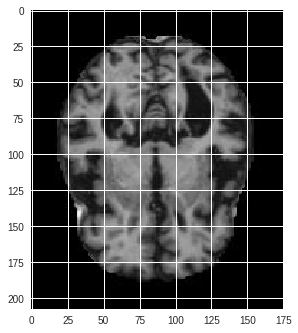

In [6]:
# Feature extraction on single image
img = train_data[0][0] #PIL image
img_gray = img.convert('L') #Converting to grayscale
img_arr = np.array(img_gray) #Converting to array
plt.imshow(img)

In [20]:
train_data[0][1] # mild demented

0

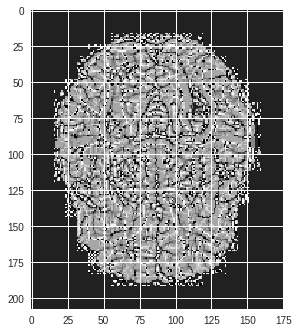

In [11]:
# Finding LBP
# For getting the texture
feat_lbp = local_binary_pattern(img_arr,8,1,'uniform') #Radius = 1, No. of neighbours = 8
feat_lbp = np.uint8((feat_lbp/feat_lbp.max())*255) #Converting to unit8
# lbp_img = PIL.Image.fromarray(feat_lbp) #Conversion from array to PIL image
plt.imshow(feat_lbp) #Displaying LBP

In [13]:
# Energy and Entropy of LBP feature
lbp_hist,_ = np.histogram(feat_lbp,8)
lbp_hist = np.array(lbp_hist,dtype=float)
lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
lbp_energy = np.sum(lbp_prob**2)
lbp_entropy = -np.sum(np.multiply(lbp_prob,np.log2(lbp_prob)))
print('LBP energy = '+str(lbp_energy))
print('LBP entropy = '+str(lbp_entropy))



LBP energy = 0.32325068209898705
LBP entropy = 2.1782987228452058


In [14]:
# Finding GLCM features from co-occurance matrix
gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True) # Co-occurance matrix
contrast = greycoprops(gCoMat, prop='contrast')
dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
homogeneity = greycoprops(gCoMat, prop='homogeneity')
energy = greycoprops(gCoMat, prop='energy')
correlation = greycoprops(gCoMat, prop='correlation')
print('Contrast = '+str(contrast[0][0]))
print('Dissimilarity = '+str(dissimilarity[0][0]))
print('Homogeneity = '+str(homogeneity[0][0]))
print('Energy = '+str(energy[0][0]))
print('Correlation = '+str(correlation[0][0]))



Contrast = 345.56283156498677
Dissimilarity = 9.781222369584437
Homogeneity = 0.48409272116505836
Energy = 0.4372697858687803
Correlation = 0.9424142926079172


/usr/local/lib/python3.6/dist-packages/skimage/feature/texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


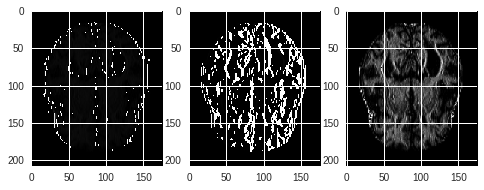

In [15]:
# Gabor filter
gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
# Displaying the filter response
fig, ax = plt.subplots(1,3)    
ax[0].imshow(gaborFilt_real,cmap='gray')
ax[1].imshow(gaborFilt_imag,cmap='gray')
ax[2].imshow(gaborFilt,cmap='gray')



In [16]:
# Energy and Entropy of Gabor filter response
gabor_hist,_ = np.histogram(gaborFilt,8)
gabor_hist = np.array(gabor_hist,dtype=float)
gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
gabor_energy = np.sum(gabor_prob**2)
gabor_entropy = -np.sum(np.multiply(gabor_prob,np.log2(gabor_prob)))
print('Gabor energy = '+str(gabor_energy))
print('Gabor entropy = '+str(gabor_entropy))

Gabor energy = 0.541411325269191
Gabor entropy = 1.3535283133672198


In [34]:
# Generating training data by extracting features from all images
label = []
featLength = 2+5+2
trainFeats = np.zeros((len(train_data),featLength)) #Feature vector of each image is of size 1x1030
for tr in range(len(train_data)):
#     print(str(tr+1)+'/'+str(len(trainDset)))
    img = train_data[tr][0] #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))   
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)
    trainFeats[tr,:] = concat_feat #Stacking features vectors for each image
    # Class label
    label.append(train_data[tr][1])
trainLabel = np.array(label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/skimage/feature/texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


In [42]:
# Generating testing data by extracting features from all images
label = []
testFeats = np.zeros((len(test_data),featLength)) #Feature vector of each image is of size 1x1030
for ts in range(len(test_data)):
#     print(str(ts+1)+'/'+str(len(testDset)))
    img = test_data[ts][0] #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)    
    testFeats[ts,:] = concat_feat  #Stacking features vectors for each image
    # Class label
    label.append(test_data[ts][1])
testLabel = np.array(label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.6/dist-packages/skimage/feature/texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


In [0]:
from sklearn.preprocessing import normalize

In [0]:
trainFeatsNorm = normalize(trainFeats)
testFeatsNorm = normalize(testFeats)

In [49]:
# Saving normalized training data and labels
with open("trainFeats.pckl", "wb") as f:
    pickle.dump(trainFeatsNorm, f)
with open("trainLabel.pckl", "wb") as f:
    pickle.dump(trainLabel, f)
    
# Saving normalized testing data and labels
with open("testFeats.pckl", "wb") as f:
    pickle.dump(testFeatsNorm, f)
with open("testLabel.pckl", "wb") as f:
    pickle.dump(testLabel, f)
    
print('Files saved to disk!')

Files saved to disk!
